In [1]:
ENV_NAME = 'MountainCarContinuous-v0'

In [2]:
import numpy as np
import random
from matplotlib import pyplot as plt

import gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
env = gym.make(ENV_NAME)

/home/hogun/anaconda2/envs/gym/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [6]:
input_dim = 2
action_dim = 2
cuda = False

In [7]:
action_list = [env.action_space.low[0], env.action_space.high[0]]

In [8]:
learning_rate = 1e-3

max_buff_size = 5000
batch_size = 64
gamma = 0.99

update_freq = 5000
print_freq = 1000

In [9]:
def get_action(q_net, inputs, epsilon, action_dim=3):
    # randomly choose
    if random.random() <= epsilon:
        action_idx = random.randint(0, action_dim-1)
    else:
        q_value = q_net(inputs).tolist()
        action_idx = np.argmax(q_value)
    
    return action_idx

In [10]:
class QNet(nn.Module):
    def __init__(self, input_dim=2, action_dim=3):
        super(QNet, self).__init__()
        self.fc1 = nn.Linear(2, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, action_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [11]:
def calculate_loss(minibatch, gamma=0.99, cuda=False):
    rewards = torch.tensor((minibatch[:, 2]).astype(np.float32))
    done = torch.tensor((1-minibatch[:, 4]).astype(np.float32))
    next_q = target_net(torch.tensor(np.concatenate(minibatch[:,3], axis=0).reshape(-1, input_dim), dtype=torch.float32))
    next_q_max = next_q[torch.arange(batch_size), next_q.max(1)[1]]
    y_target = rewards + gamma * done * next_q_max
    #print('y target:', y_target)
    
    pre_obs = torch.tensor(np.concatenate(minibatch[:,0], axis=0).reshape(-1, input_dim), dtype=torch.float32)
    if cuda:
        y_target = y_target.cuda()
        pre_obs = pre_obs.cuda()
    
    q_values = q_net(pre_obs)
    actions = minibatch[:, 1].astype(np.int32)
    max_q = q_values[torch.arange(batch_size), actions]
    #print('q:', max_q)
    loss = criterion(y_target, max_q)
    
    return loss

In [17]:
q_net = QNet(input_dim, action_dim)
target_net = QNet(input_dim, action_dim)

if cuda:
    q_net = q_net.cuda()

target_net.load_state_dict(q_net.state_dict())
criterion = nn.MSELoss(reduction='mean')
#optimizer = optim.SGD(q_net.parameters(), lr=1e-6, momentum=0.95)
optimizer = optim.Adam(q_net.parameters(), lr=learning_rate)

epsilon = 1.0
min_epsilon = 0.01

replay_buffer = []
log_returns = []
log_average_loss = []
log_minibatch_loss = []

done = False
t_step = 0
ridx = 0
episode_reward = 0
running_loss = 0
observation = env.reset()

while t_step<500000:
    #env.render()
    pre_obs = observation
    input_state = torch.tensor([observation], dtype=torch.float32)
    if cuda:
        input_state = input_state.cuda()
    action_idx = get_action(q_net, input_state, epsilon, action_dim)
    observation, reward, done, info = env.step([action_list[action_idx]])
    
#     if observation[0] >= 0.5:
#         reward += 10
    
    epsilon = max(0.999*epsilon, min_epsilon)

    episode_reward += reward
    if done:
        #print('new episode.')
        log_returns.append(episode_reward)
        episode_reward = 0
        observation = env.reset()

    if len(replay_buffer)<max_buff_size:
        replay_buffer.append([pre_obs, action_idx, reward, observation, done])
        if len(replay_buffer)<batch_size:
            continue
    else:
        replay_buffer[ridx%max_buff_size] = [pre_obs, action_idx, reward, observation, done]
        ridx += 1

    minibatch = np.array(random.sample(replay_buffer, batch_size))
    loss = calculate_loss(minibatch).cpu()
    running_loss += loss.data.numpy()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (t_step+1)%print_freq==0:
        print(t_step+1, 'step average loss:', running_loss/print_freq)
        log_average_loss.append(running_loss/print_freq)
        running_loss = 0
    log_minibatch_loss.append(loss.data.numpy())

    if (t_step+1)%update_freq:
        target_net.load_state_dict(q_net.state_dict())

    t_step += 1

1000 step average loss: 0.005249139919906156
2000 step average loss: 0.03910052082852053
3000 step average loss: 0.04274629194680892
4000 step average loss: 2.3801667232392503
5000 step average loss: 3.887019426566083
6000 step average loss: 4.746083925120533
7000 step average loss: 1.9463472854942083
8000 step average loss: 1.5646575100272895
9000 step average loss: 0.7959038783162832
10000 step average loss: 0.47596411349624396
11000 step average loss: 0.4243933352679014
12000 step average loss: 0.38082261064648626
13000 step average loss: 0.531771592579782
14000 step average loss: 0.45777800238877536
15000 step average loss: 0.6970184894800187
16000 step average loss: 0.8870736328065395
17000 step average loss: 0.7228013489246369
18000 step average loss: 0.46052476853132246
19000 step average loss: 0.37173819380253553
20000 step average loss: 0.3475290470793843
21000 step average loss: 0.39468723184242843
22000 step average loss: 7.702227892786264
23000 step average loss: 1.72478318

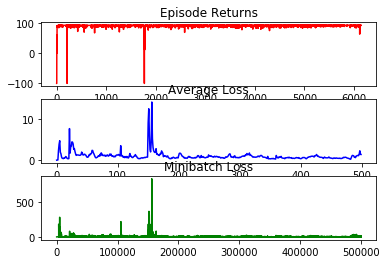

In [18]:
labels = ['Episode Returns', 'Average Loss', 'Minibatch Loss']
colors = ['red', 'blue', 'green']

fig, axes = plt.subplots(3)
axes[0].plot(log_returns, color=colors[0])
axes[1].plot(log_average_loss, color=colors[1])
axes[2].plot(log_minibatch_loss, color=colors[2])
for i in range(3):
    axes[i].set_title(labels[i])